In [89]:
from numpy import *
from qutip  import *
from matplotlib.pyplot import *
import numpy as np
import qutip as qt
from qutip import *
import matplotlib.pyplot as plt
from numpy import pi
import h5py
from scipy.optimize import curve_fit
%matplotlib inline


# Reference: Novikov's Ph.D thesis
### Note that in this code the notation follows the thesis instead of the paper.
### i.e. The probe is for the |g,0> -> |e,1> two photon transition, and  the coupler is for the cavity like transition of |e,0> -> |e,1>.

[Characterization of lambda systems
using superconducting qubits](https://uwspace.uwaterloo.ca/bitstream/handle/10012/12409/Percival_Helen.pdf?sequence=3&isAllowed=y)

[Raman coherence effects in a superconducting Jaynes-Cummings system](https://drum.lib.umd.edu/handle/1903/16910)

In [11]:
def H_CPT(N,del_c, del_p, Omega_c, Omega_p, chi,kappa,Gamma,dephase):
    # Hamiltonian form is given by equation 7.3 from Novokov's thesis
    
    # del_x: detuning from the transitions
    # Omega_x: Rabi frequency for each transitions
    # chi is the dispersive shift, and note that the cavity freq difference when qubit is at |e> or |g> is 2*chi  
    # Qubit subspace: 2x2, Cavity subspace: N+1 x N+1
    g =basis(2,0)
    e = basis(2,1)
    
    term1 = -(del_c+2*chi)*tensor(g*g.dag(),num(N+1))
    term2 = -del_p*tensor(e*e.dag() ,qeye(N+1))-del_c *(tensor(e*e.dag(),num(N+1))-tensor(e*e.dag(),qeye(N+1)))
    term3 = (Omega_c/2)*tensor(e*e.dag(),create(N+1))
    term4 = qt.tensor(qt.basis(2,1), qt.basis(N+1,1))*(tensor(qt.basis(2,0), qt.basis(N+1,0)).dag()) * Omega_p/2
    H = term1 + term2 + term3 + term4 + (term3+term4).dag() 
    
    A_cav   = tensor(qeye(2),destroy(N+1))*np.sqrt(kappa)
    A_relax   = tensor(destroy(2),qeye(N+1))*np.sqrt(Gamma)
    A_dephase = tensor( sigmaz(), qeye(N+1)) * np.sqrt(dephase)
    return H,[A_cav,A_relax,A_dephase]

In [45]:
def CPT_Spectrum(N, Omega_c, Omega_p, 
                 chi, kappa, Gamma, dephase,
                 del_list,
                 del_control, control="Probe"):
    
    spec = np.zeros(len( del_list), dtype=np.float64)
    speci = np.zeros(len( del_list), dtype=np.float64)
    pop_g0 = np.zeros(len( del_list), dtype=np.float64)
    pop_e0 = np.zeros(len( del_list), dtype=np.float64)
    pop_e1 = np.zeros(len( del_list), dtype=np.float64)
    
    def spectrum(H, c_ops):
        rho_ss= steadystate(H, c_ops,solver='scipy')
        spec = rho_ss[N+1, (N+2)].imag
        speci = rho_ss[N+1, (N+2)].real
        pop_g0 = rho_ss[0, 0].real
        pop_e0 =expect(num(2) ,ptrace(rho_ss,0))
        pop_e1 =rho_ss[N+2, N+2].real
        return spec, pop_g0, pop_e0, pop_e1 ,speci
    
    if control=="Probe":
        for i, del_c in enumerate(del_list):
            H ,c_ops = H_CPT(N,del_c,del_control, Omega_c, Omega_p, chi,kappa,Gamma,dephase)
            spec[i], pop_g0[i], pop_e0[i], pop_e1[i],speci[i] = spectrum(H ,c_ops)
    
    else:
        for i, del_p in enumerate(del_list):
            H ,c_ops = H_CPT(N,del_control,del_p, Omega_c, Omega_p, chi,kappa,Gamma,dephase)
            spec[i], pop_g0[i], pop_e0[i], pop_e1[i],speci[i] = spectrum(H ,c_ops)
            
    return pop_e0, pop_g0, pop_e1, spec,speci

In [8]:
N = 9
start=-20
end=20
point=201

chi = -1* (2*np.pi) #dispersive shift
Omega_c = 0.5* (2*np.pi)
Omega_p = 3* (2*np.pi)

kappa = 7 * (2*np.pi)
Gamma = 0.1 
dephase = 0.2*(2*pi)
del_list = 2*pi*np.linspace(start, end, point)

sweep_range=2
resolution=21
detune = 2*pi*linspace(-sweep_range,sweep_range,resolution)
z = np.zeros((resolution,point))

for i ,del_control in enumerate(detune):
    z[i]= CPT_Spectrum(N, Omega_c, Omega_p, chi,kappa,Gamma,dephase,del_list,del_control,control="Probe")

Text(0, 0.5, 'imag')

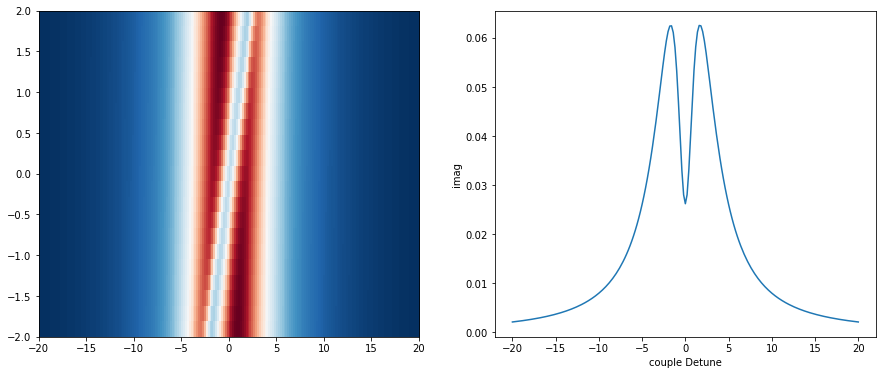

In [9]:
plt.figure(figsize=(15,6))
subplot(121)
extent = -20, 20, -2, 2
plt.imshow(z, origin="lower", aspect = "auto", cmap = "RdBu_r", interpolation = "None", extent=extent) 

subplot(122)
plt.plot(del_list/(2*pi), z[int((resolution-1)/2)])
plt.xlabel("couple Detune")
plt.ylabel("imag")

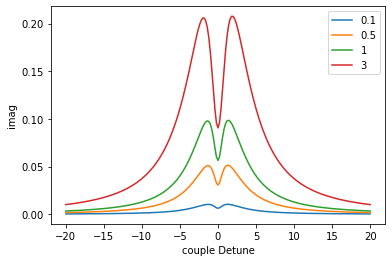

In [4]:
N = 9
start=-20
end=20
point=201
del_control=0
chi = -2* (2*np.pi) #dispersive shift
Omega_p = 2* (2*np.pi)

kappa = 7 * (2*np.pi)
Gamma = 0.1 * (2*np.pi)
dephase = 0.2*(2*pi)
del_list = 2*pi*np.linspace(start, end, point)
sweep_range=1
resolution=11
#detune = 2*pi*linspace(-sweep_range,sweep_range,resolution)
z = np.zeros((resolution,point))
detune=[0.1,0.5,1,3]
for i ,Omega_c in enumerate(detune):
    z[i]= CPT_Spectrum(N, Omega_c* (2*np.pi), Omega_p, chi,kappa,Gamma,dephase,del_list,del_control,control="Probe")
    plt.plot(del_list/(2*pi), z[i],label=Omega_c)
    plt.xlabel("couple Detune")
    plt.ylabel("imag")
plt.legend()
   # z[i+3]=steady_state_spectrum

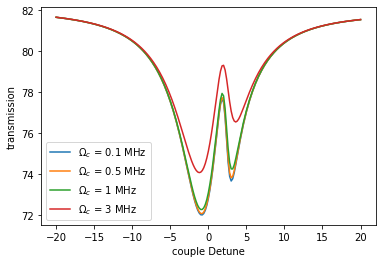

In [10]:
detune=[0.1,0.5,1,3]
ass = np.linspace(5.920e9  ,  5.960e9, 201)
for i ,Omega_c in enumerate(detune):
    z[i]= CPT_Spectrum(N, Omega_c* (2*np.pi), Omega_p, chi,kappa,Gamma,dephase,del_list,del_control,control="Probe")
    sss=multiply((1+(13)*z[i]/(Omega_c))**(1/2),ass)/(3*10**8)
    plt.plot(del_list/(2*pi),100*exp(-sss*0.01),label=f"$\Omega_c$ = {Omega_c} MHz")
    plt.xlabel("couple Detune")
    plt.ylabel("transmission")
plt.legend()

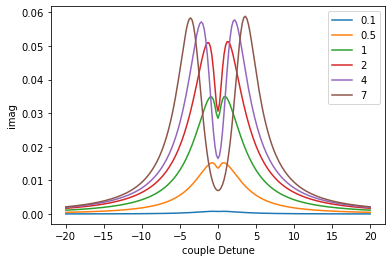

In [11]:
N = 9
start=-20
end=20
point=201
del_control=0
chi = -2* (2*np.pi) #dispersive shift
Omega_c = 0.5* (2*np.pi)

kappa = 7 * (2*np.pi)
Gamma = 0.1 * (2*np.pi)
dephase = 0.2*(2*pi)
del_list = 2*pi*np.linspace(start, end, point)
p_power= [0.1,0.5,1,2,4,7]
z = np.zeros((len(p_power),point))

for i ,Omega_p in enumerate(p_power):
    z[i]= CPT_Spectrum(N, Omega_c, Omega_p* (2*np.pi), chi,kappa,Gamma,dephase,del_list,del_control,control="Probe")
    plt.plot(del_list/(2*pi), z[i],label=Omega_p)
    plt.xlabel("couple Detune")
    plt.ylabel("imag")
plt.legend()

In [42]:
N = 13
start=-40
end=40
point=201

chi = -1.1* (2*np.pi) #dispersive shift
Omega_p = 3.5* (2*np.pi)
del_control=0
kappa = 7.9333
Gamma = 0.115 #T1=10us  T2=5us dephase = 1/(5e-6)-1/2*(10e-6)
dephase =0.012#0.23
del_list = 2*pi*np.linspace(start, end, point)

resolution=21
detune = 2*pi*linspace(3.3,20,resolution)
z = np.zeros((resolution,point))

for i ,Omega_c in enumerate(detune):
    print(i)
    z[i]= CPT_Spectrum(N, Omega_c, Omega_p, chi,kappa,Gamma,dephase,del_list,del_control,control="couple")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


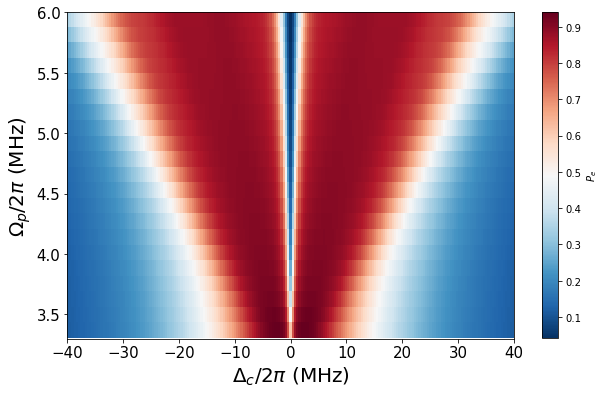

In [43]:
plt.figure(figsize=(10,6))
# subplot(121)
extent = -40, 40, 3.3, 6
plt.imshow(z, origin="lower", aspect = "auto", cmap = "RdBu_r", interpolation = "None", extent=extent) 
plt.xlabel(r"$\Delta_c/2\pi$ (MHz)",fontsize=20)
plt.ylabel(r"$\Omega_p/2\pi$ (MHz)",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.colorbar(label=r"$P_e$")

In [40]:
N = 13
start=-40
end=40
point=201

chi = -1.1* (2*np.pi) #dispersive shift
Omega_p = 2* (2*np.pi)
Omega_c = 1* (2*np.pi)
kappa = 7.9333
Gamma = 0.115 #T1=10us  T2=5us dephase = 1/(5e-6)-1/2*(10e-6)
dephase =0.012#0.23
del_list = 2*pi*np.linspace(start, end, point)

resolution=10
detune = 2*pi*linspace(-2, 3,resolution)
z = np.zeros((resolution,point))

for i ,a in enumerate(detune):
    print(a)
    z[i]= CPT_Spectrum(N, Omega_c, Omega_p, chi,kappa,Gamma,dephase,del_list,a,control="couple")

-12.566370614359172
-9.075712110370514
-5.585053606381854
-2.094395102393195
1.3962634015954642
4.886921905584122
8.377580409572783
11.868238913561443
15.3588974175501
18.84955592153876


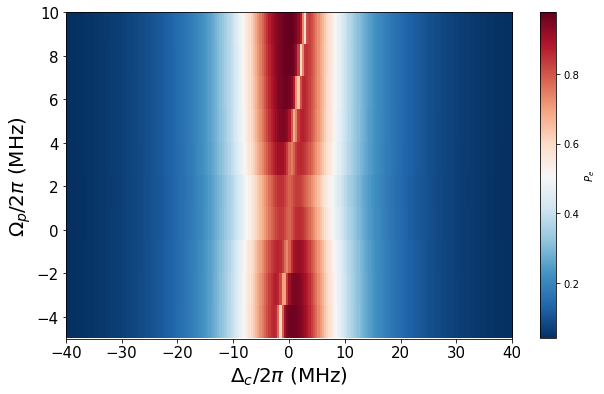

In [41]:
plt.figure(figsize=(10,6))
# subplot(121)
extent = -40, 40, -5, 10
plt.imshow(z, origin="lower", aspect = "auto", cmap = "RdBu_r", interpolation = "None", extent=extent) 
plt.xlabel(r"$\Delta_c/2\pi$ (MHz)",fontsize=20)
plt.ylabel(r"$\Omega_p/2\pi$ (MHz)",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.colorbar(label=r"$P_e$")

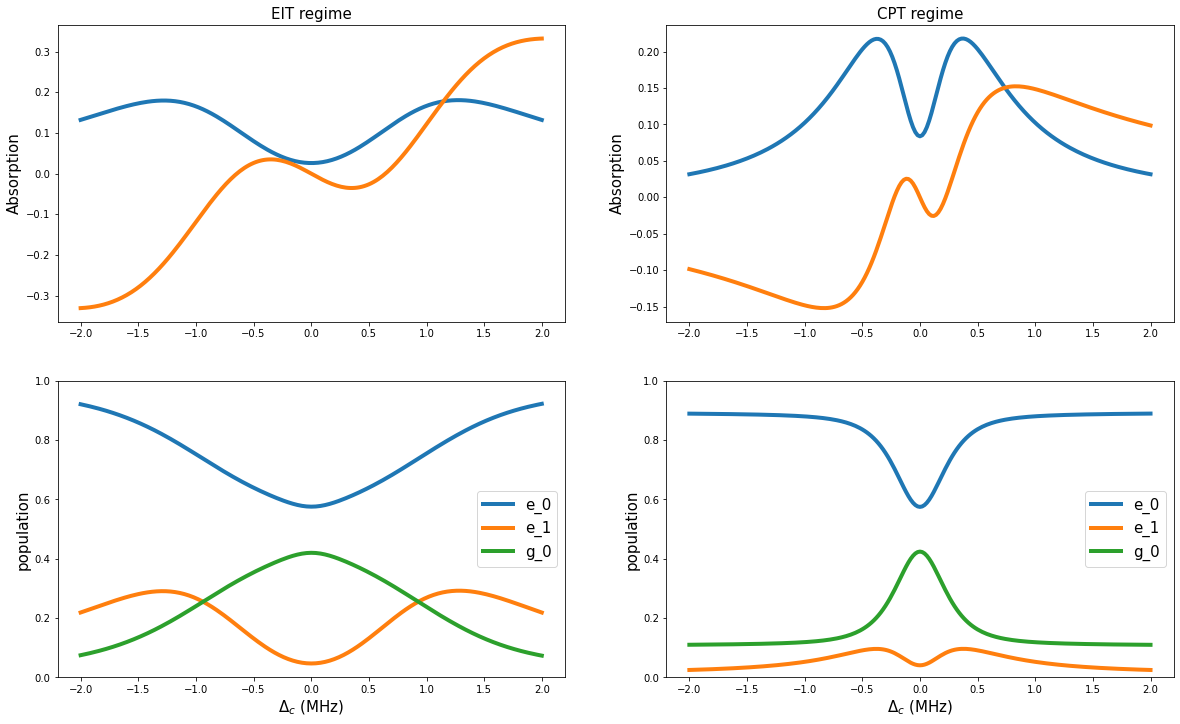

In [61]:
N = 13
start=-2
end=2
point=201
del_control=0* (2*np.pi)
chi = -1.1* (2*np.pi) #dispersive shift
Omega_p = 2* (2*np.pi)
Omega_c = 2* (2*np.pi)
kappa = 7.9333
Gamma = 0.115 #T1=10us  T2=5us dephase = 1/(5e-6)-1/2*(10e-6)
dephase =0.012#0.230.012
del_list = 2*pi*np.linspace(start, end, point)

e_0 = np.zeros(point)
e_1 = np.zeros(point)
g_0 = np.zeros(point)
spect = np.zeros(point)
speci = np.zeros(point)

plt.figure(figsize=(20,12))
e_0, g_0, e_1, spect,speci= CPT_Spectrum(N, Omega_c, Omega_p, chi,kappa,Gamma,dephase,del_list,del_control,control="Probe")

plt.subplot(2,2,1)
plt.plot(del_list/(2*pi), spect,label="spec",linewidth=4)
plt.plot(del_list/(2*pi), speci,label="speci",linewidth=4)
plt.ylabel("Absorption",fontsize=15)
plt.title("EIT regime",fontsize=15)
plt.subplot(2,2,3)
plt.plot(del_list/(2*pi),e_0,label="e_0",linewidth=4)
plt.plot(del_list/(2*pi), e_1,label="e_1",linewidth=4)
plt.plot(del_list/(2*pi), g_0,label="g_0",linewidth=4)
plt.xlabel(r"$\Delta_c$ (MHz)",fontsize=15)
plt.ylabel("population",fontsize=15)
plt.legend(fontsize=15)
plt.ylim([0,1])

e_0, g_0, e_1, spect,speci= CPT_Spectrum(N,  0.5 * (2*np.pi),  0.5 * (2*np.pi), chi,kappa,Gamma,dephase,del_list,del_control,control="Probe")

plt.subplot(2,2,2)
plt.plot(del_list/(2*pi), spect,label="spec",linewidth=4)
plt.plot(del_list/(2*pi), speci,label="speci",linewidth=4)
plt.ylabel("Absorption",fontsize=15)
plt.title("CPT regime",fontsize=15)

plt.subplot(2,2,4)
plt.plot(del_list/(2*pi),e_0,label="e_0",linewidth=4)
plt.plot(del_list/(2*pi), e_1,label="e_1",linewidth=4)
plt.plot(del_list/(2*pi), g_0,label="g_0",linewidth=4)
plt.ylabel("population",fontsize=15)
plt.xlabel(r"$\Delta_c$ (MHz)",fontsize=15)
plt.ylim([0,1])
plt.legend(fontsize=15)

data shape: (801, 6, 8)


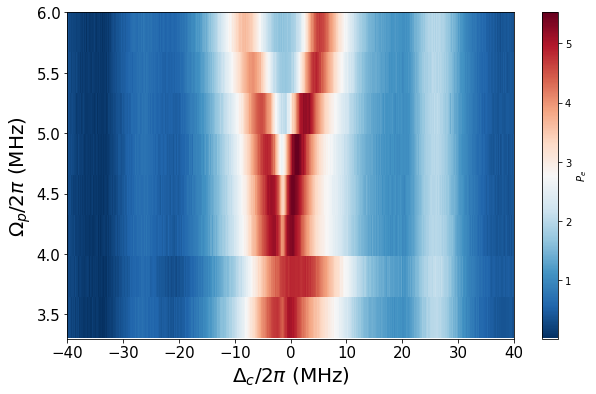

In [83]:
directory = 'C:\\Users\\user\\SynologyDrive\\DESKTOP-V6JLHQU\\C\\Users\\cluster\\Labber\\Data\\2022\\08\\Data_0817'
fname = '3Dtransmon002_CPT_sweep_probe_power_002.hdf5'
path = directory + '\\' + fname
idx=3

with h5py.File(path,'r') as hf:
    #print(hf.keys())
    raw_data = np.copy(hf["Data"]["Data"])
    print("data shape:", raw_data.shape)
    
resonace=5307.4

mag = np.zeros((8,801))
freq = np.zeros(801)
for i in range(8):
    freq = raw_data[:,0,i] * 1e-6
    Data = raw_data[:,4,i] + 1j*raw_data[:,5,i]
    mag[i]  = np.abs(Data) * 1e+3 

extent = -40, 40, 3.3, 6
plt.figure(figsize=(10,6))
plt.imshow(mag, origin="lower", aspect = "auto", cmap = "RdBu_r", interpolation = "None", extent=extent) 
plt.xlabel(r"$\Delta_c/2\pi$ (MHz)",fontsize=20)
plt.ylabel(r"$\Omega_p/2\pi$ (MHz)",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.colorbar(label=r"$P_e$")

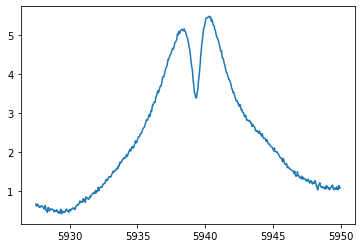

In [111]:
plt.plot(freq[150:600],mag[3][150:600])

(2.817445923949844,
 -3.2172176729591064,
 3.3105356774665298,
 0.8099849239929161)

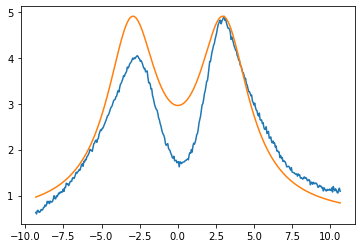

In [228]:
data=mag[6][200:600]
freq1=freq[200:600]-5939.31
def ATS(f, A_1, w1,gamma1,S_0):
    return (A_1*gamma1)/((f-w1)**2+(1/4)*gamma1**2)+(A_1*gamma1)/((f+w1)**2+(1/4)*gamma1**2)+S_0
guess = [ max(data),-3,4,0]
qopt, qcov = curve_fit(ATS, freq1,data, guess)
plt.plot(freq1,data)
plt.plot(freq1, ATS(freq1, 4, 3, 4,0.5))
#plt.plot(freq1, ATS(freq1, qopt[0], qopt[1], qopt[2], qopt[3], qopt[4],qopt[5], qopt[6]))
(qopt[0], qopt[1], qopt[2], qopt[3])

(3.399636939908586, -1.646274241440354, 4.47675707888592, 0.7012165267172281)

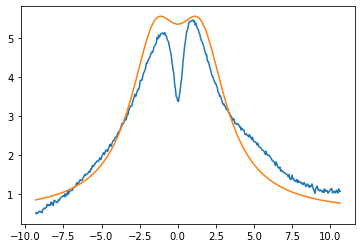

In [229]:
data=mag[3][200:600]
freq1=freq[200:600]-5939.31
def ATS(f, A_1, w1,gamma1,S_0):
    return (A_1*gamma1)/((f-w1)**2+(1/4)*gamma1**2)+(A_1*gamma1)/((f+w1)**2+(1/4)*gamma1**2)+S_0
guess = [ max(data),-3,4,0]
qopt, qcov = curve_fit(ATS, freq1,data, guess)
plt.plot(freq1,data)
plt.plot(freq1, ATS(freq1, 3.8, 1.5, 4,0.5))
#plt.plot(freq1, ATS(freq1, qopt[0], qopt[1], qopt[2], qopt[3], qopt[4],qopt[5], qopt[6]))
(qopt[0], qopt[1], qopt[2], qopt[3])